In [ ]:
# Upgrade Oracle ADS to pick up latest features and maintain compatibility with Oracle Cloud Infrastructure.

!pip install -U oracle-ads

<font color=gray>Oracle Data Science service sample notebook.

Copyright (c) 2025 Oracle, Inc.  All rights reserved.
Licensed under the Universal Permissive License v 1.0 as shown at https://oss.oracle.com/licenses/upl.
</font>

***
# <font color=red>Train and Deploy an XGBoost Model for OCI NoSQL</font>
<p style="margin-left:10%; margin-right:10%;">by the <font color=teal> Oracle NoSQL PM Team </font></p>

***

## Overview:

The `XGBoostModel` class in Accelerated Data Science (ADS) allows you to rapidly get a model into production. The `.prepare()` method creates the model artifacts that are needed to deploy a functioning model without you having to configure it or write code, including the ability to customize the `score.py` file as needed. The model can be subsequently verified, saved, and deployed.

Compatible conda pack: [General Machine Learning](https://docs.oracle.com/en-us/iaas/data-science/using/conda-gml-fam.htm) for CPU on Python 3.11 (version 1.0)

### Prequisites

This notebook requires authorization to work with the OCI Data Science Service. Details can be found [here](https://accelerated-data-science.readthedocs.io/en/latest/user_guide/cli/authentication.html#). For the purposes of this notebook what is important to to know is that resource principals will be used absent api_key authentication.


In [ ]:
import ads
import logging
import tempfile
import warnings

from ads.common.model_metadata import UseCaseType
from ads.model.framework.xgboost_model import XGBoostModel
from shutil import rmtree
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import xgboost

logging.basicConfig(format="%(levelname)s:%(message)s", level=logging.ERROR)
warnings.filterwarnings("ignore")

<a id='intro'></a>
# Introduction

## Authenticate

Authentication to the OCI Data Science service is required. Here we default to resource principals.

In [ ]:
ads.set_auth(auth="resource_principal")

Install Pip Packages

In [ ]:
!pip install -U pandas
!pip install -U xgboost

!pip install -U seaborn
!pip install -U numpy
!pip install -U prophet
!pip install -U scikit-learn

!pip install -U oci
!pip install -U borneo

## Import Necessary Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from prophet import Prophet
from IPython.display import display

# Import NoSQL Libraries

from borneo import (NoSQLHandle, NoSQLHandleConfig , AuthorizationProvider,
                    TableLimits, State,
                    PutRequest,QueryRequest, DeleteRequest, TableRequest, GetRequest, PutOption, QueryIterableResult )

from borneo.iam import SignatureProvider
from borneo.kv import StoreAccessTokenProvider


c:\Users\DAVEGA\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Connecting to Oracle NoSQL



In [ ]:
def get_connection():
    # Learn more https://nosql-python-sdk.readthedocs.io/en/stable/installation.html#configuring-the-sdk
    provider = StoreAccessTokenProvider()
    config = NoSQLHandleConfig( 'http://node1-nosql:8080', provider).set_logger(None)
    return(NoSQLHandle(config))

def get_connection_cloud():
    # Learn more https://nosql-python-sdk.readthedocs.io/en/stable/installation.html#configuring-the-sdk
	# replace the placeholder with your region identifier
	region = "eu-paris-1"
	provider = SignatureProvider()
	# It is using the DEFAULT profile with the config file in default location (~/.oci/config). 
    # It is possible to configure using other auth methods (Resource Principals, Instance Principals, etc)
    # https://docs.oracle.com/en/cloud/paas/nosql-cloud/dtddt/index.html#GUID-B09F1A47-98E4-4F02-AB23-5D4284F481F4
	config = NoSQLHandleConfig(region, provider)
	# replace the placeholder with the ocid of your compartment
	config.set_default_compartment("ocid1.compartment.oc1..aaaaaaaa4mlehopmvdluv2wjcdp4tnh2ypjz3nhhpahb4ss7yvxaa3be3diq")
	return(NoSQLHandle(config))


handle = get_connection_cloud()

## Creating Oracle NoSQL Table

In [18]:
with open('train-nosql-table-xgboost.sql', 'r') as file:
    statement = file.read().rstrip()
request = TableRequest().set_statement(statement).set_table_limits(TableLimits(30, 10, 1))
handle.do_table_request(request, 50000, 3000)


## Creating Oracle NoSQL JSON Collection Table

Currently available only on-premises

In [4]:
statement = ('Create table if not exists {} ( sku String, primary key(sku)) as JSON collection ').format("ProductData")
request = TableRequest().set_statement(statement).set_table_limits(TableLimits(30, 10, 1))
handle.do_table_request(request, 50000, 3000)
print('After create JSON Collectiontable')

After create JSON Collectiontable


## Loading Data to  Oracle NoSQL Table


In [ ]:
import json

with open('train-nosql-data-xgboost.json', 'r') as f:
    stats = json.load(f)

# Iterating through the json list
request = PutRequest().set_table_name("ProductData")
for i in stats:
    request.set_value(i)
    handle.put(request)


## Reading Data from  Oracle NoSQL Table


### read_oracle_nosql is a generic function executing a SQL query and returning a panda frame


In [ ]:
def read_oracle_nosql (sqlstmt, handle):
	request = QueryRequest().set_statement(sqlstmt)
	qiresult = handle.query_iterable(request)
	items = []
	for row in qiresult:
		items.append(dict(row))
		   
	df= pd.DataFrame(items)
	return df

### SELECT all the rows from ProductData table

In [ ]:
statement = "SELECT * FROM ProductData"
df= read_oracle_nosql(statement, handle)


# pandas.read_sql_query or pandas.read_sql_table has the parameter coerce_float bool, default True
# Attempts to convert values of non-string, non-numeric objects (like decimal.Decimal) to floating point. Can result in loss of Precision.
#
# pandas.Datafreame has the parameter dtypedtype, default None
# Data type to force. Only a single dtype is allowed. If None, infer.

# Currently I am simulating this behavior to specific fields when needed;
# df['average_days_between_sales'] = df['average_days_between_sales'].astype(float)
# df['rev_last_30_days'] = df['rev_last_30_days'].astype(float)
# df['demand_forecast_days_cover'] = df['demand_forecast_days_cover'].astype(float)
# df['brand'] = df['brand'].astype('string')

# Learn more about NoSQL Datatypes https://nosql-python-sdk.readthedocs.io/en/stable/datatypes.html


print(df.dtypes)

df



,sku,age_buckets,average_days_between_sales,brand,category,conversion_rate,days_oos,days_since_added,days_since_last_received,days_since_last_sold,...,revenue,rrp,sell_through_rate,soh,stock,stock_bucket,stock_cost,stock_margin,stock_value,type
0,SKU892459,AgeGroup5,29.72,Brand44,Category11,66.83,57,274,235,33,...,425.19,102.62,49.56%,599,640,Overstock,712.54,56.19,3488.83,Variant
1,SKU892927,AgeGroup5,15.04,Brand48,Category13,40.40,81,78,303,12,...,778.37,42.57,50.97%,544,363,Overstock,737.87,48.76,9160.17,Simple
2,SKU893053,AgeGroup4,30.70,Brand26,Category18,62.17,52,307,219,4,...,6054.68,31.65,57.65%,955,399,Overstock,4354.61,91.80,5615.73,Variant
3,SKU893212,AgeGroup3,20.54,Brand2,Category12,0.80,29,341,83,85,...,4335.86,89.46,16.38%,35,987,Understock,4232.81,45.64,161.60,Variant
4,SKU893218,AgeGroup3,19.38,Brand17,Category6,46.66,22,187,180,36,...,4913.83,76.01,45.74%,254,282,Overstock,3770.45,18.08,1637.71,Variant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9996,SKU901045,AgeGroup4,23.06,Brand14,Category9,98.56,59,63,122,166,...,9077.61,52.03,7.55%,852,570,Overstock,1572.80,88.57,3741.49,Simple
9997,SKU901050,AgeGroup2,24.48,Brand7,Category11,45.55,59,260,25,19,...,3990.52,70.80,82.73%,248,623,Overstock,3409.41,10.88,7548.95,Simple
9998,SKU901187,AgeGroup4,20.52,Brand26,Category11,12.49,82,19,277,107,...,5500.44,32.23,14.17%,78,470,Overstock,1526.69,19.75,5191.37,Simple
9999,SKU901592,AgeGroup4,29.26,Brand0,Category4,13.66,1,127,197,175,...,2157.72,66.25,84.68%,630,633,Understock,4536.21,30.59,2677.61,Simple


## Preparing Data


In [8]:

# Prepare the data
X = df[['days_since_last_sold', 'average_days_between_sales', 'stock', 
        'orders_last_30_days', 'rev_last_30_days', 'demand_forecast_days_cover']].copy()
y = df['qty_sold'].copy()

# Ensure safe modifications
X.loc[:, 'days_since_last_sold'] = pd.to_datetime(X['days_since_last_sold'], errors='coerce').map(lambda x: x.toordinal() if pd.notnull(x) else np.nan)

# Drop rows with NaN values if any due to datetime conversion
X = X.dropna()
y = y.loc[X.index]  # Ensure y matches the filtered X

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Train the Models

In [9]:
def train_models(X_train, y_train, X_test):
    # XGBoost
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=5, learning_rate=0.1)
    xgb_model.fit(X_train, y_train)
    xgb_pred = xgb_model.predict(X_test)

    # Linear Regression
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)

    # Random Forest
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    return xgb_pred, lr_pred, rf_pred


## Evaluate the Models

In [10]:
def evaluate_models(y_test, xgb_pred, lr_pred, rf_pred):
    # Evaluate Models
    xgb_mae = mean_absolute_error(y_test, xgb_pred)
    lr_mae = mean_absolute_error(y_test, lr_pred)
    rf_mae = mean_absolute_error(y_test, rf_pred)

    # Display Mean Absolute Errors
    print(f'XGBoost MAE: {xgb_mae:.4f}')
    print(f'Linear Regression MAE: {lr_mae:.4f}')
    print(f'Random Forest MAE: {rf_mae:.4f}')

## Visualise the Prediction

In [11]:
def visualize_predictions(y_test, xgb_pred, lr_pred, rf_pred):
    # Visualize predictions
    plt.figure(figsize=(12,6))
    plt.plot(y_test.values, label='Actual Stock Sold', linestyle='dotted')
    plt.plot(xgb_pred, label='XGBoost Prediction', linestyle='dashed')
    plt.plot(lr_pred, label='Linear Regression Prediction', linestyle='dashed')
    plt.plot(rf_pred, label='Random Forest Prediction', linestyle='dashed')
    plt.legend()
    plt.title('Actual vs Predicted Stock Levels - Multiple Models')
    plt.show()

## Forecast with Prophet

In [12]:
def forecast_with_prophet(df):
    # Prophet Forecasting
    df_prophet = df[['days_since_last_sold', 'qty_sold']].copy()
    df_prophet.columns = ['ds', 'y']
    
    # Ensure modifications are on a copy
    df_prophet = df_prophet.copy()
    df_prophet.loc[:, 'ds'] = pd.to_datetime(df_prophet['ds'], errors='coerce')

    # Remove rows with invalid dates
    df_prophet = df_prophet.dropna(subset=['ds'])

    # Train Prophet model
    model_prophet = Prophet()
    model_prophet.fit(df_prophet)
    future = model_prophet.make_future_dataframe(periods=30)
    forecast = model_prophet.predict(future)

    # Visualize forecast
    model_prophet.plot(forecast)
    plt.title('Sales Forecast with Prophet')
    plt.show()

    # Display forecasted results
    display(forecast)



## Evaluate, Train, Visualize and Forecast

XGBoost MAE: 250.2998
Linear Regression MAE: 247.6823
Random Forest MAE: 251.2228


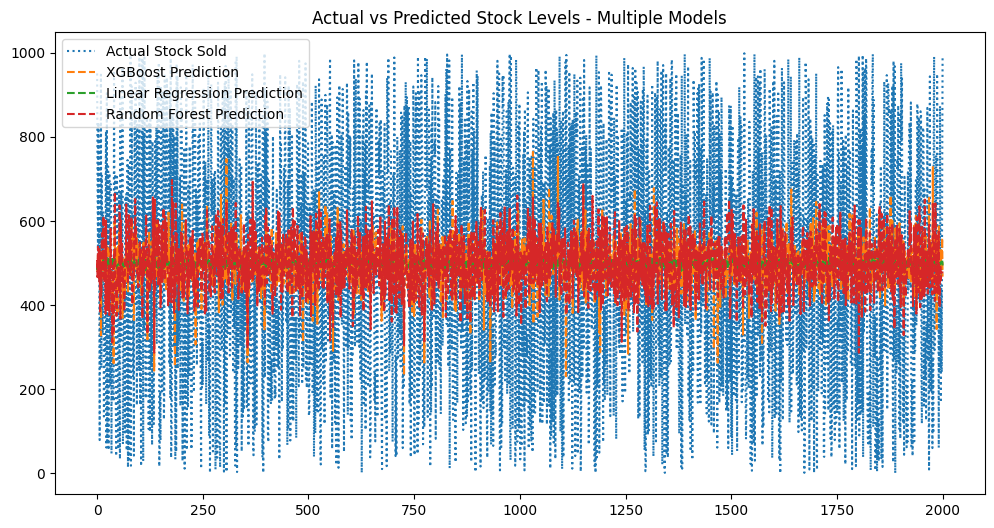

C:\Users\DAVEGA\AppData\Local\Temp\ipykernel_4604\1787319259.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['1970-01-01 00:00:00.000000033', '1970-01-01 00:00:00.000000012',
 '1970-01-01 00:00:00.000000004', '1970-01-01 00:00:00.000000085',
 '1970-01-01 00:00:00.000000036', '1970-01-01 00:00:00.000000019',
 '1970-01-01 00:00:00.000000138', '1970-01-01 00:00:00.000000069',
 '1970-01-01 00:00:00.000000155', '1970-01-01 00:00:00.000000056',
 ...
 '1970-01-01 00:00:00.000000015', '1970-01-01 00:00:00.000000118',
 '1970-01-01 00:00:00.000000077', '1970-01-01 00:00:00.000000132',
 '1970-01-01 00:00:00.000000169', '1970-01-01 00:00:00.000000166',
 '1970-01-01 00:00:00.000000019', '1970-01-01 00:00:00.000000107',
 '1970-01-01 00:00:00.000000175', '1970-01-01 00:00:00.000000177']
Length: 10001, dtype: datetime64[ns]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.

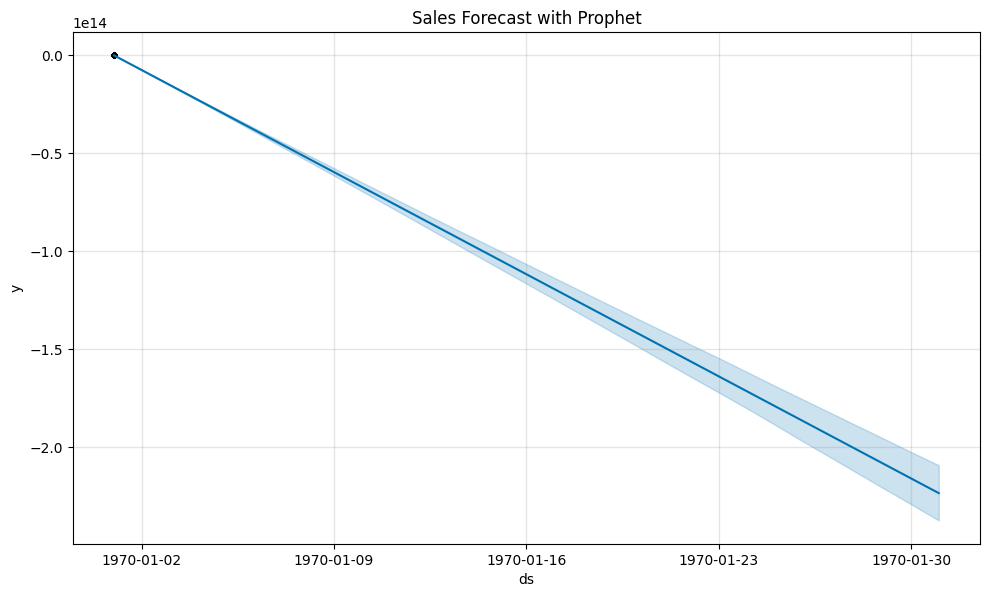

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1970-01-01 00:00:00.000000000,5.054131e+02,1.392143e+02,8.658739e+02,5.054131e+02,5.054131e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.054131e+02
1,1970-01-01 00:00:00.000000001,5.053505e+02,1.283598e+02,8.501474e+02,5.053505e+02,5.053505e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.053505e+02
2,1970-01-01 00:00:00.000000002,5.052880e+02,1.152434e+02,8.541103e+02,5.052880e+02,5.052880e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.052880e+02
3,1970-01-01 00:00:00.000000003,5.052255e+02,1.288127e+02,8.788064e+02,5.052255e+02,5.052255e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.052255e+02
4,1970-01-01 00:00:00.000000004,5.051629e+02,1.639515e+02,8.582063e+02,5.051629e+02,5.051629e+02,0.0,0.0,0.0,0.0,0.0,0.0,5.051629e+02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,1970-01-27 00:00:00.000000179,-1.938187e+14,-2.048561e+14,-1.821958e+14,-2.048561e+14,-1.821958e+14,0.0,0.0,0.0,0.0,0.0,0.0,-1.938187e+14
206,1970-01-28 00:00:00.000000179,-2.012732e+14,-2.130883e+14,-1.890096e+14,-2.130883e+14,-1.890096e+14,0.0,0.0,0.0,0.0,0.0,0.0,-2.012732e+14
207,1970-01-29 00:00:00.000000179,-2.087278e+14,-2.212865e+14,-1.957921e+14,-2.212865e+14,-1.957921e+14,0.0,0.0,0.0,0.0,0.0,0.0,-2.087278e+14
208,1970-01-30 00:00:00.000000179,-2.161824e+14,-2.293536e+14,-2.026965e+14,-2.293536e+14,-2.026965e+14,0.0,0.0,0.0,0.0,0.0,0.0,-2.161824e+14


In [13]:
# Train models
xgb_pred, lr_pred, rf_pred = train_models(X_train, y_train, X_test)

# Evaluate models
evaluate_models(y_test, xgb_pred, lr_pred, rf_pred)

# Visualize predictions
visualize_predictions(y_test, xgb_pred, lr_pred, rf_pred)

# Forecast with Prophet
forecast_with_prophet(df)

## Output

In [ ]:
XGBoost MAE: 252.8182
Linear Regression MAE: 248.9368
Random Forest MAE: 254.1496

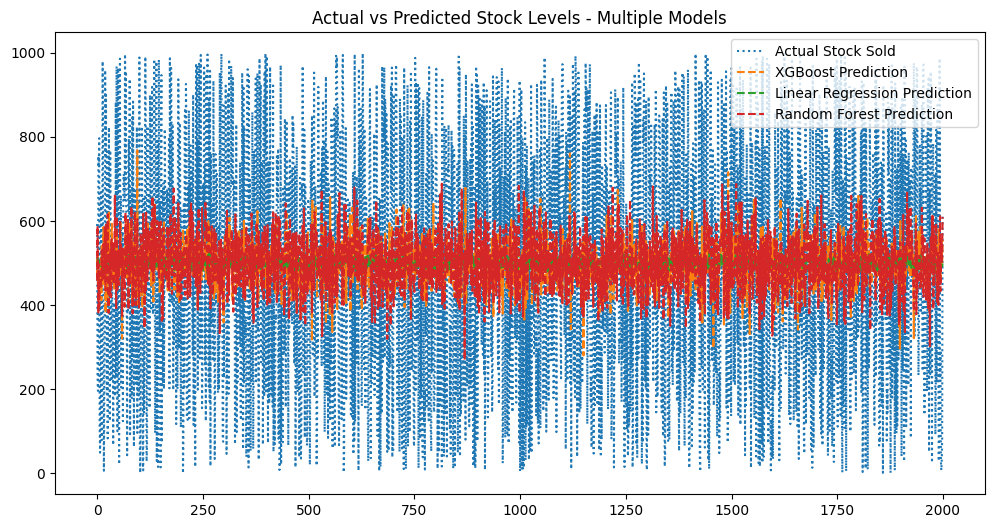

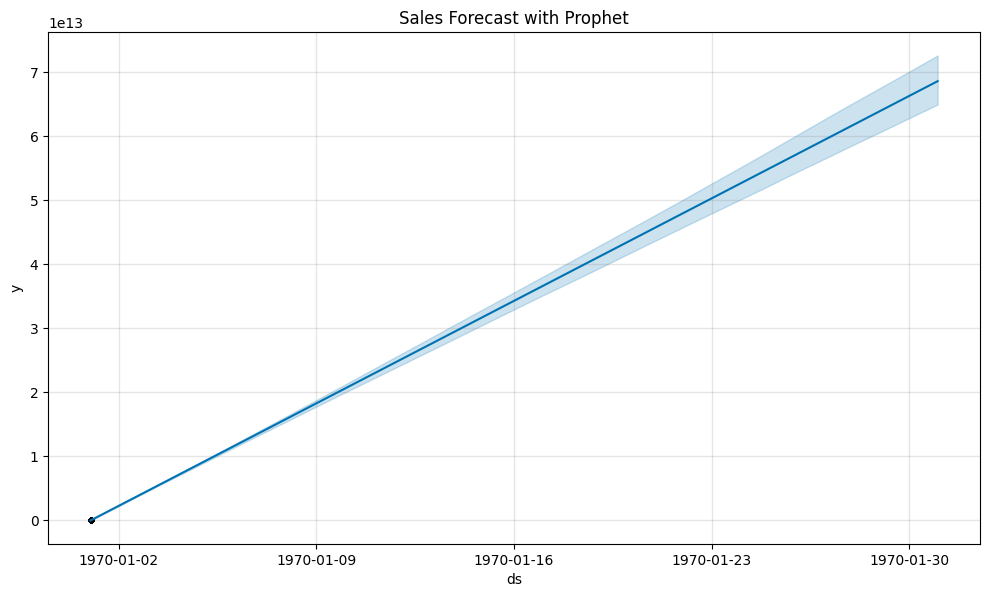

<a id='ref'></a>
# References
- [ADS Library Documentation](https://accelerated-data-science.readthedocs.io/en/latest/index.html)
- [Data Science YouTube Videos](https://www.youtube.com/playlist?list=PLKCk3OyNwIzv6CWMhvqSB_8MLJIZdO80L)
- [OCI Data Science Documentation](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/data-science.htm)
- [Oracle Data & AI Blog](https://blogs.oracle.com/datascience/)
- [Understanding Conda Environments](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/use-notebook-sessions.htm#conda_understand_environments)
- [Use Resource Manager to Configure Your Tenancy for Data Science](https://docs.cloud.oracle.com/en-us/iaas/data-science/using/orm-configure-tenancy.htm)
- [`runtime.yaml`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_runtime_yaml.htm#model_runtime_yaml)
- [`score.py`](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/model_score_py.htm#model_score_py)
- [Model artifact](https://docs.content.oci.oracleiaas.com/en-us/iaas/data-science/using/models_saving_catalog.htm#create-models)
- [ONNX API Summary](http://onnx.ai/sklearn-onnx/api_summary.html)